In [1]:
# dependencies import
from common_dependencies import *
from itertools import chain
import logging
logger = logging.getLogger('main.make_pred.ipynb')

2024-03-25 13:35:35.664908: E external/local_xla/xla/stream_executor/plugin_registry.cc:91] Invalid plugin kind specified: FFT
2024-03-25 13:35:35.705550: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE3 SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-25 13:35:36.071046: E external/local_xla/xla/stream_executor/plugin_registry.cc:91] Invalid plugin kind specified: DNN


In [2]:
# paths for files with original data
PATH_TO_DATA = {
    'run_1': 
        ('data/original_data/run_1/run1_WM32_data.csv',
        'data/original_data/run_1/run1_WM32_defects.csv',
        'data/original_data/run_1/run1_WM32_pipe.csv'),
    'run_2':
        ('data/original_data/run_2/run2_WM32_data.csv',
        'data/original_data/run_2/run2_WM32_defects.csv',
        'data/original_data/run_2/run2_WM32_pipe.csv')
}


PATH_TO_MODEL = 'networks/CNN'
RUNS = [1, 2]
MODEL_VER = '09'
MODEL_NUM = '02'
XSHIFT = 200

for name in os.listdir(PATH_TO_MODEL):
    res = re.match(F'(id=v{MODEL_VER}n{MODEL_NUM}).*', name)
    if not res is None:
        PATH_TO_MODEL += '/' + res[0]
        break

# детерминация случайных величин, отвечающих за выбор первоначальных весов и биасов
tf.compat.v1.set_random_seed(290)
tf.random.set_seed(290)

In [3]:
# Загрузка модели
load_model = keras.models.load_model(PATH_TO_MODEL)
CROP_SIZE = load_model.inputs[0].shape[1]
CROP_STEPS = [CROP_SIZE, CROP_SIZE//2, CROP_SIZE//4]

2024-03-25 13:35:37.098642: I external/local_xla/xla/stream_executor/rocm/rocm_executor.cc:924] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-03-25 13:35:37.124748: I external/local_xla/xla/stream_executor/rocm/rocm_executor.cc:924] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-03-25 13:35:37.124815: I external/local_xla/xla/stream_executor/rocm/rocm_executor.cc:924] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-03-25 13:35:37.126354: I external/local_xla/xla/stream_executor/rocm/rocm_executor.cc:924] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-03-25 13:35:37.126435: I external/local_xla/xla/stream_executor/rocm/rocm_executor.

In [4]:
'''def fill_by_arrays(df_cell_value):
    return list()
    

    
def add_number_to_arrays(df_cell_value, number):
    df_cell_value.append(number)
    return df_cell_value

extend_size_result_df = pd.DataFrame(data=0, 
                         columns=[1,2,3], 
                         index=[1,2,3])

extend_size_result_df = extend_size_result_df.map(fill_by_arrays)

print(extend_size_result_df)

extend_size_result_df = extend_size_result_df.map(lambda x: add_number_to_arrays(x, 5))

print(extend_size_result_df)'''

'def fill_by_arrays(df_cell_value):\n    return list()\n    \n\n    \ndef add_number_to_arrays(df_cell_value, number):\n    df_cell_value.append(number)\n    return df_cell_value\n\nextend_size_result_df = pd.DataFrame(data=0, \n                         columns=[1,2,3], \n                         index=[1,2,3])\n\nextend_size_result_df = extend_size_result_df.map(fill_by_arrays)\n\nprint(extend_size_result_df)\n\nextend_size_result_df = extend_size_result_df.map(lambda x: add_number_to_arrays(x, 5))\n\nprint(extend_size_result_df)'

In [5]:
def make_pred_fast(model, 
                   path_to_data_tuple: tuple(),
                   x_shift: int,
                   crop_size: int, 
                   crop_step: int):

    x_df, y_df = dw.get_x_and_y_data(*path_to_data_tuple)

    x_df = dw.roll_df(x_df, x_shift, 1)
    y_df = dw.roll_df(y_df, x_shift, 1)

    or_rows = x_df.shape[0]
    or_cols = x_df.shape[1]
    ex_x_df = dw.extend_df_for_prediction(x_df, crop_size)
    ex_x_df = dw.extend_df_for_crops_dividing(ex_x_df, crop_size, crop_step)
    ex_y_df = dw.extend_df_for_prediction(y_df, crop_size)
    ex_y_df = dw.extend_df_for_crops_dividing(ex_y_df, crop_size, crop_step)
    ex_rows = ex_x_df.shape[0]
    ex_cols = ex_x_df.shape[1]
    
    x_arr = dw.df_to_numpy(ex_x_df)
    y_arr = ex_y_df.to_numpy()
    
    x_arr_time = dw.standardize_data(x_arr[:,:,:32])
    x_arr_amp = dw.standardize_data(x_arr[:,:,32:])
    y_arr = dw.standardize_data(y_arr)
    
    x_arr_time_crops_gen = dw.get_crop_generator(x_arr_time, crop_size, crop_step)
    x_arr_amp_crops_gen = dw.get_crop_generator(x_arr_amp, crop_size, crop_step)
    y_data_binary_gen = (1 if np.sum(crop > 0) else 0 for crop in 
                         dw.get_crop_generator(y_arr, crop_size, crop_step))
    y_data_depth_gen = (np.max(crop) for crop in 
                        dw.get_crop_generator(y_arr, crop_size, crop_step))

    x_time = np.stack([crop for crop in x_arr_time_crops_gen])
    x_amp = np.stack([crop for crop in x_arr_amp_crops_gen])
    y_binary = np.array([binary for binary in y_data_binary_gen])
    y_depth = np.array([depth for depth in y_data_depth_gen])

    # 1 output
    res = model.predict([x_time, x_amp])[:,0]
    res_it = iter(res)

    # 2 outputs
    '''res = np.array(model.predict([x_data_time, x_data_amp]))
    res = np.squeeze(res, axis=2)
    
    bool_res = res[0,:]
    depth_res = res[1,:]

    extend_size_arr = np.ones((ex_rows, ex_cols))     
    
    bool_res_it = iter(bool_res) 
    depth_res_it = iter(depth_res) '''
    
    def fill_by_arrays(df_cell_value):
        return list()
    def add_number_to_arrays(df_cell_value, number):
        df_cell_value.append(number)
        return df_cell_value
    extend_size_result_df = pd.DataFrame(data=0, 
                             columns=ex_x_df.columns, 
                             index=ex_x_df.index)
    extend_size_result_df = extend_size_result_df.map(fill_by_arrays)

    for i in range(0, ex_rows - crop_size + 1, crop_step):
        for j in range(0,  ex_cols - crop_size + 1, crop_step):
            temp_add = next(res_it)
            extend_size_result_df.iloc[i:i+crop_size, j:j+crop_size] = \
                extend_size_result_df.iloc[i:i+crop_size, j:j+crop_size].map(lambda x: add_number_to_arrays(x, temp_add))

    orig_size_result_df = extend_size_result_df.iloc[crop_size:, crop_size:].iloc[:or_rows, :or_cols]
    
    return orig_size_result_df, extend_size_result_df, y_df, ex_y_df 

In [6]:
'''values = [0.1,0.15,0.06,1]

x = np.quantile(values, [0,0.25,0.5,0.75,1]) 
print(x)'''

'values = [0.1,0.15,0.06,1]\n\nx = np.quantile(values, [0,0.25,0.5,0.75,1]) \nprint(x)'

main.make_pred.ipynb ::             <module>() :: run: 1, crop step: 16
main.custom_modules.data_worker.data_worker ::     get_x_and_y_data() :: 
    Read detectors data shape: (115, 400)
    Read defect data shape: (115, 400)
main.custom_modules.data_worker._dataframe_utils :: extend_df_for_prediction() :: 
    The input df shape: (115, 400)
    The crop size: 16
    The output df shape: (145, 430)
main.custom_modules.data_worker._dataframe_utils :: extend_df_for_crops_dividing() :: 
    The input df shape: (145, 430)
    The crop size: 16
    The crop step: 16
    The output df shape: (160, 432)
main.custom_modules.data_worker._dataframe_utils :: extend_df_for_prediction() :: 
    The input df shape: (115, 400)
    The crop size: 16
    The output df shape: (145, 430)
main.custom_modules.data_worker._dataframe_utils :: extend_df_for_crops_dividing() :: 
    The input df shape: (145, 430)
    The crop size: 16
    The crop step: 16
    The output df shape: (160, 432)
main.custom_modul

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


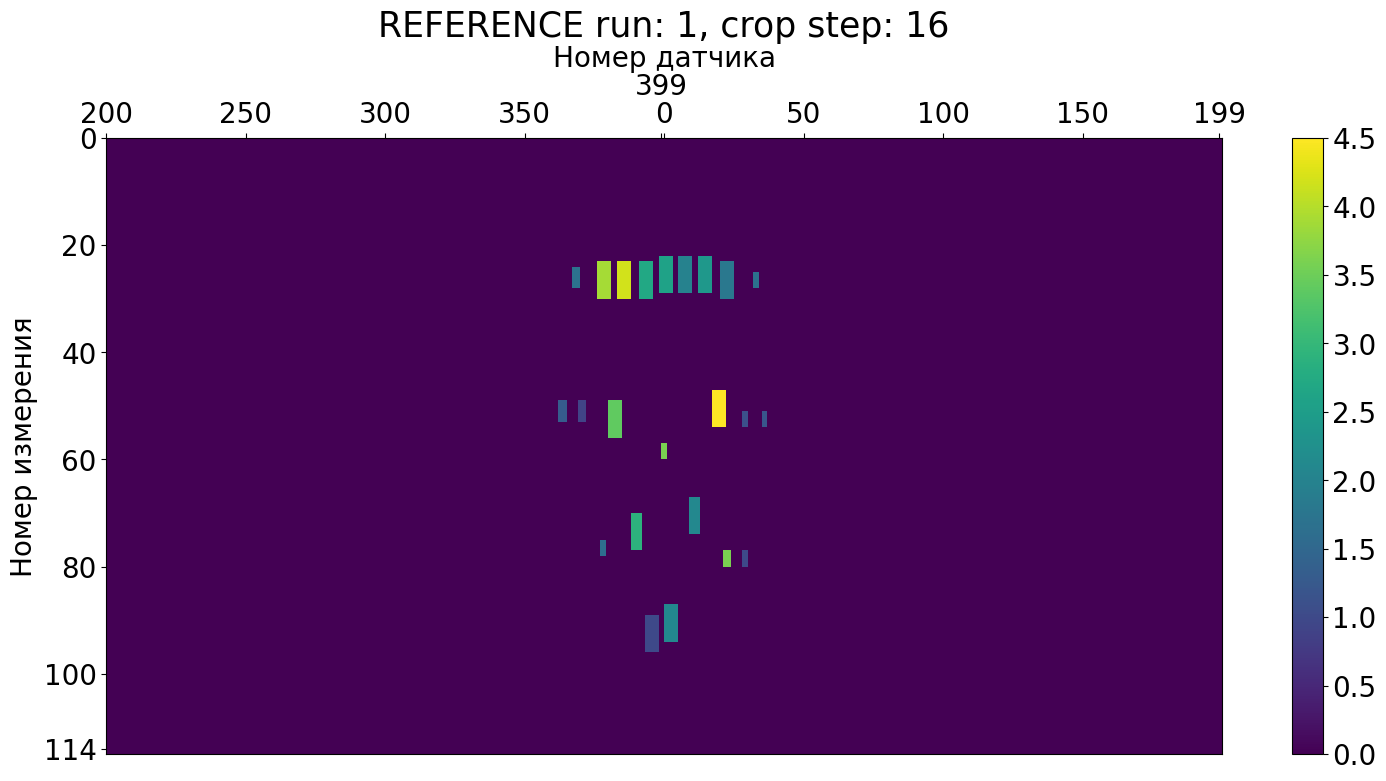

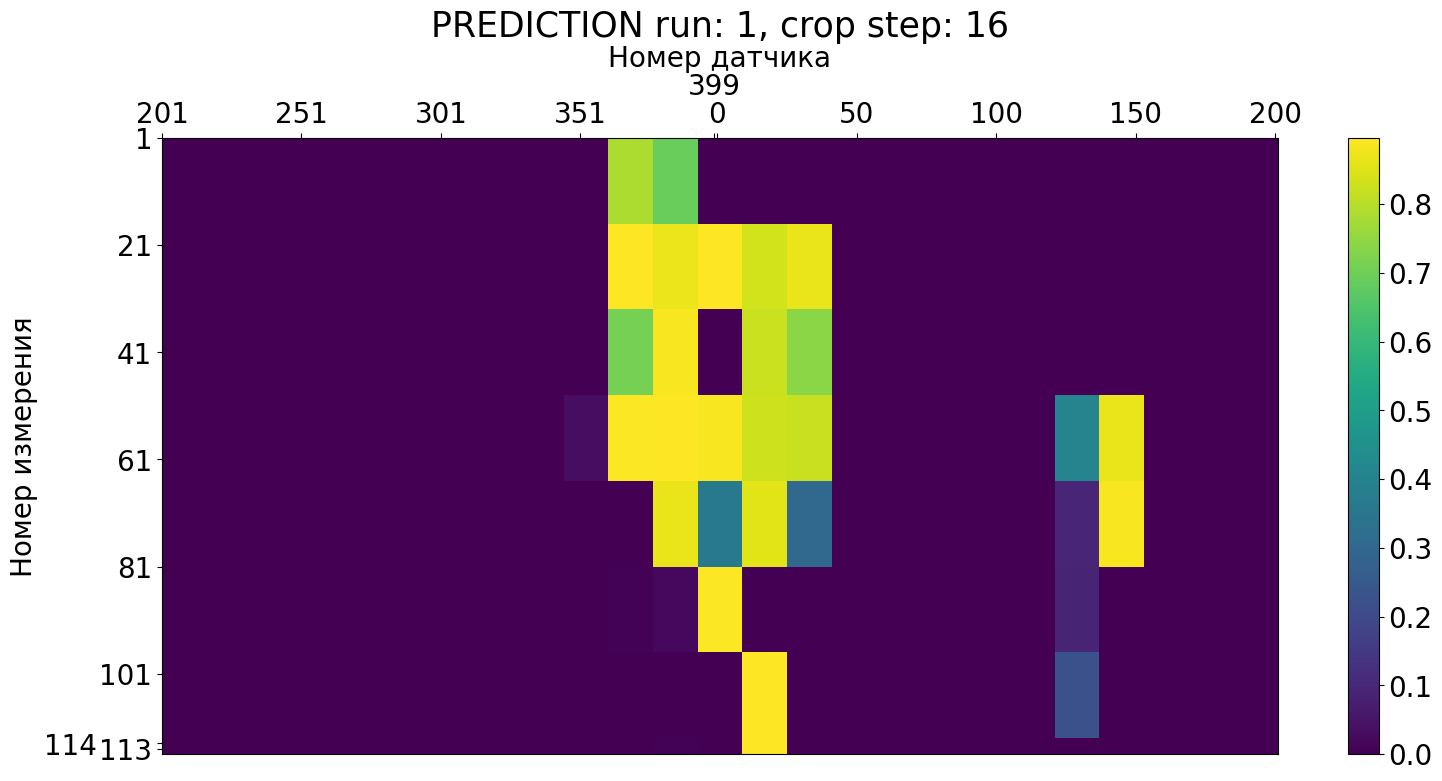

main.make_pred.ipynb ::             <module>() :: run: 1, crop step: 8
main.custom_modules.data_worker.data_worker ::     get_x_and_y_data() :: 
    Read detectors data shape: (115, 400)
    Read defect data shape: (115, 400)
main.custom_modules.data_worker._dataframe_utils :: extend_df_for_prediction() :: 
    The input df shape: (115, 400)
    The crop size: 16
    The output df shape: (145, 430)
main.custom_modules.data_worker._dataframe_utils :: extend_df_for_crops_dividing() :: 
    The input df shape: (145, 430)
    The crop size: 16
    The crop step: 8
    The output df shape: (152, 432)
main.custom_modules.data_worker._dataframe_utils :: extend_df_for_prediction() :: 
    The input df shape: (115, 400)
    The crop size: 16
    The output df shape: (145, 430)
main.custom_modules.data_worker._dataframe_utils :: extend_df_for_crops_dividing() :: 
    The input df shape: (145, 430)
    The crop size: 16
    The crop step: 8
    The output df shape: (152, 432)
main.custom_modules.

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


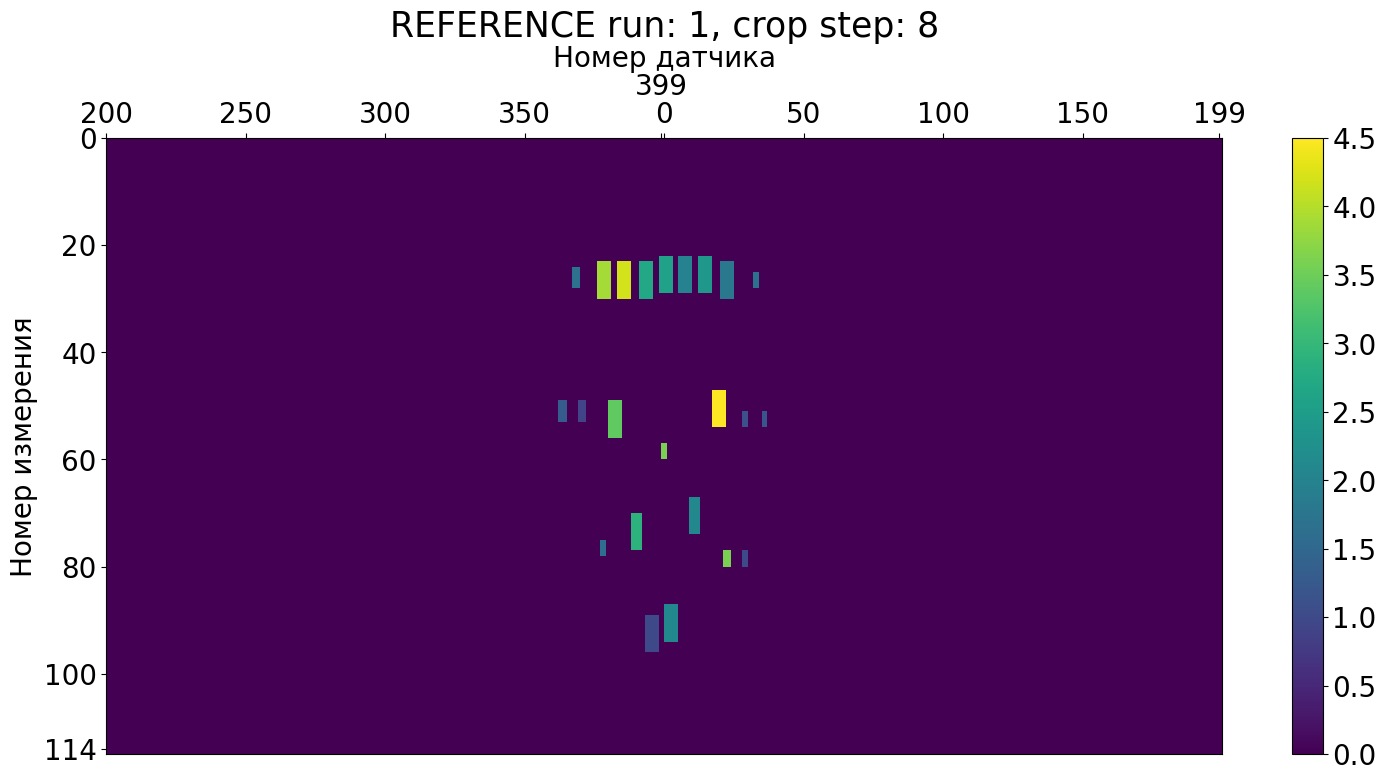

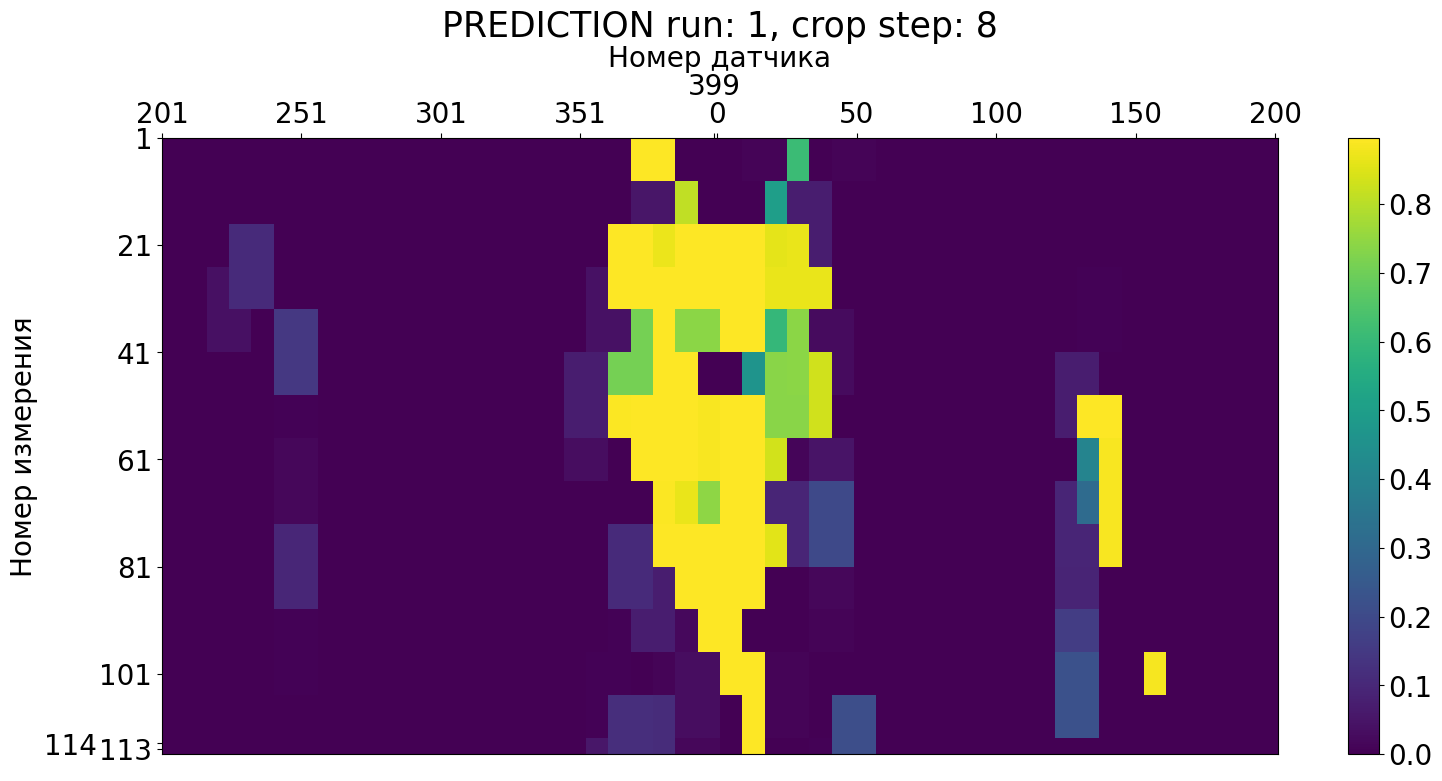

main.make_pred.ipynb ::             <module>() :: run: 1, crop step: 4
main.custom_modules.data_worker.data_worker ::     get_x_and_y_data() :: 
    Read detectors data shape: (115, 400)
    Read defect data shape: (115, 400)
main.custom_modules.data_worker._dataframe_utils :: extend_df_for_prediction() :: 
    The input df shape: (115, 400)
    The crop size: 16
    The output df shape: (145, 430)
main.custom_modules.data_worker._dataframe_utils :: extend_df_for_crops_dividing() :: 
    The input df shape: (145, 430)
    The crop size: 16
    The crop step: 4
    The output df shape: (148, 432)
main.custom_modules.data_worker._dataframe_utils :: extend_df_for_prediction() :: 
    The input df shape: (115, 400)
    The crop size: 16
    The output df shape: (145, 430)
main.custom_modules.data_worker._dataframe_utils :: extend_df_for_crops_dividing() :: 
    The input df shape: (145, 430)
    The crop size: 16
    The crop step: 4
    The output df shape: (148, 432)
main.custom_modules.

112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


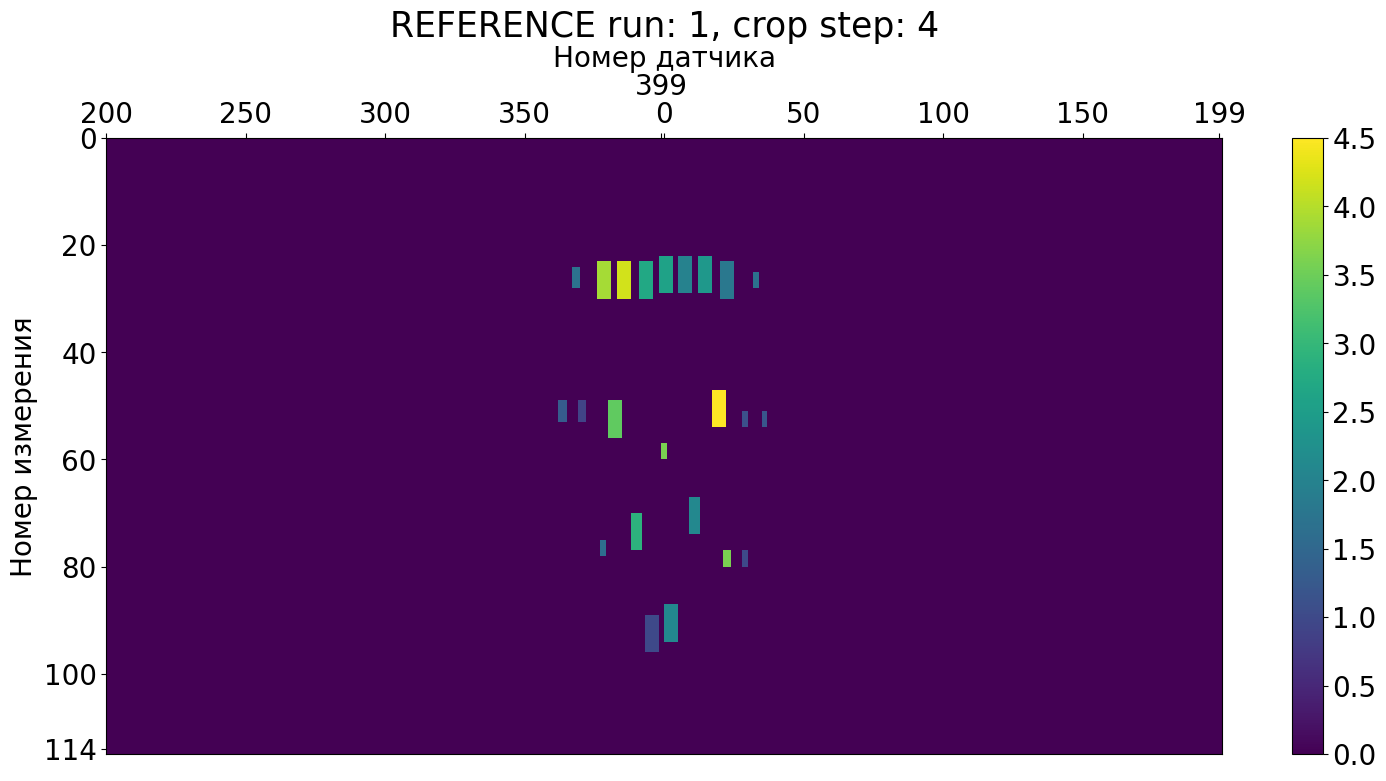

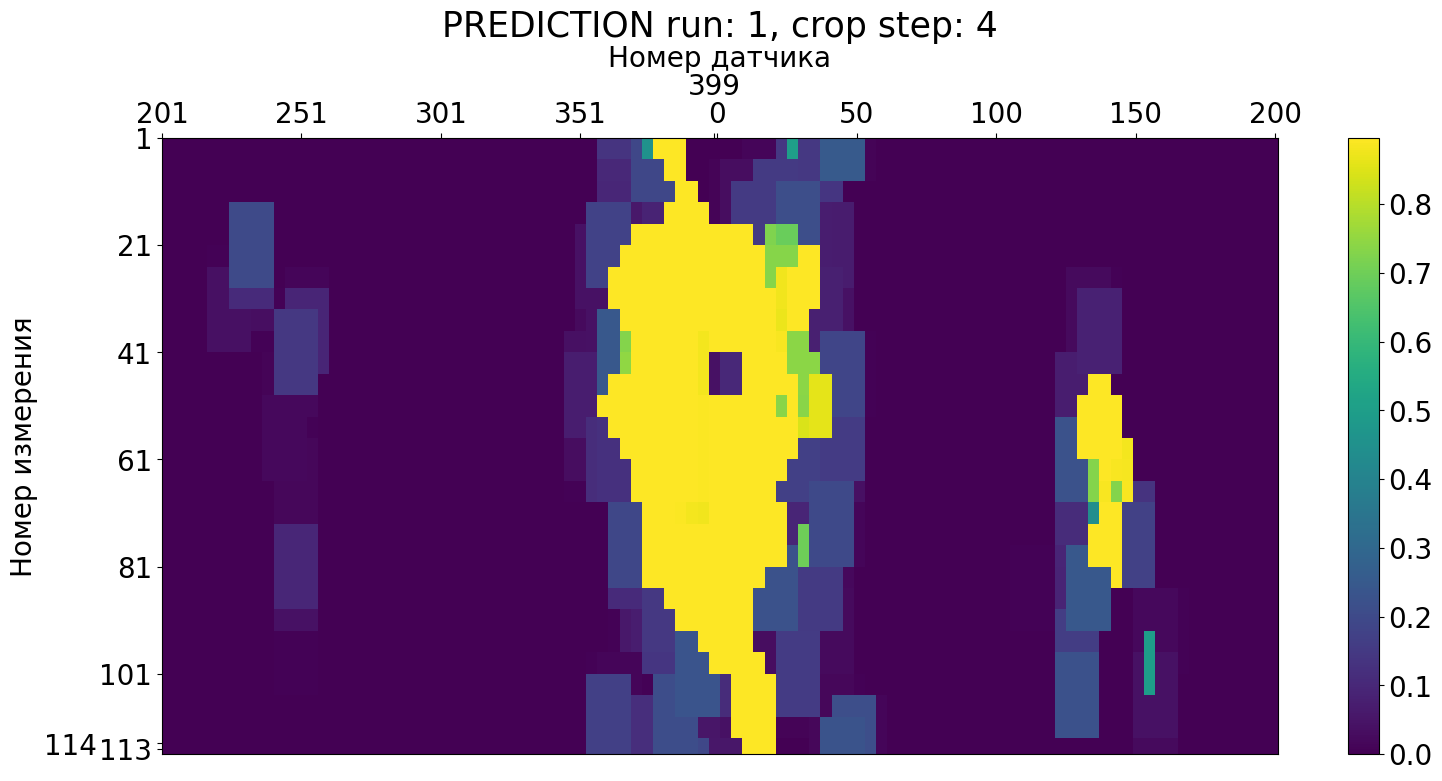

main.make_pred.ipynb ::             <module>() :: run: 2, crop step: 16
main.custom_modules.data_worker.data_worker ::     get_x_and_y_data() :: 
    Read detectors data shape: (119, 400)
    Read defect data shape: (119, 400)
main.custom_modules.data_worker._dataframe_utils :: extend_df_for_prediction() :: 
    The input df shape: (119, 400)
    The crop size: 16
    The output df shape: (149, 430)
main.custom_modules.data_worker._dataframe_utils :: extend_df_for_crops_dividing() :: 
    The input df shape: (149, 430)
    The crop size: 16
    The crop step: 16
    The output df shape: (160, 432)
main.custom_modules.data_worker._dataframe_utils :: extend_df_for_prediction() :: 
    The input df shape: (119, 400)
    The crop size: 16
    The output df shape: (149, 430)
main.custom_modules.data_worker._dataframe_utils :: extend_df_for_crops_dividing() :: 
    The input df shape: (149, 430)
    The crop size: 16
    The crop step: 16
    The output df shape: (160, 432)
main.custom_modul

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


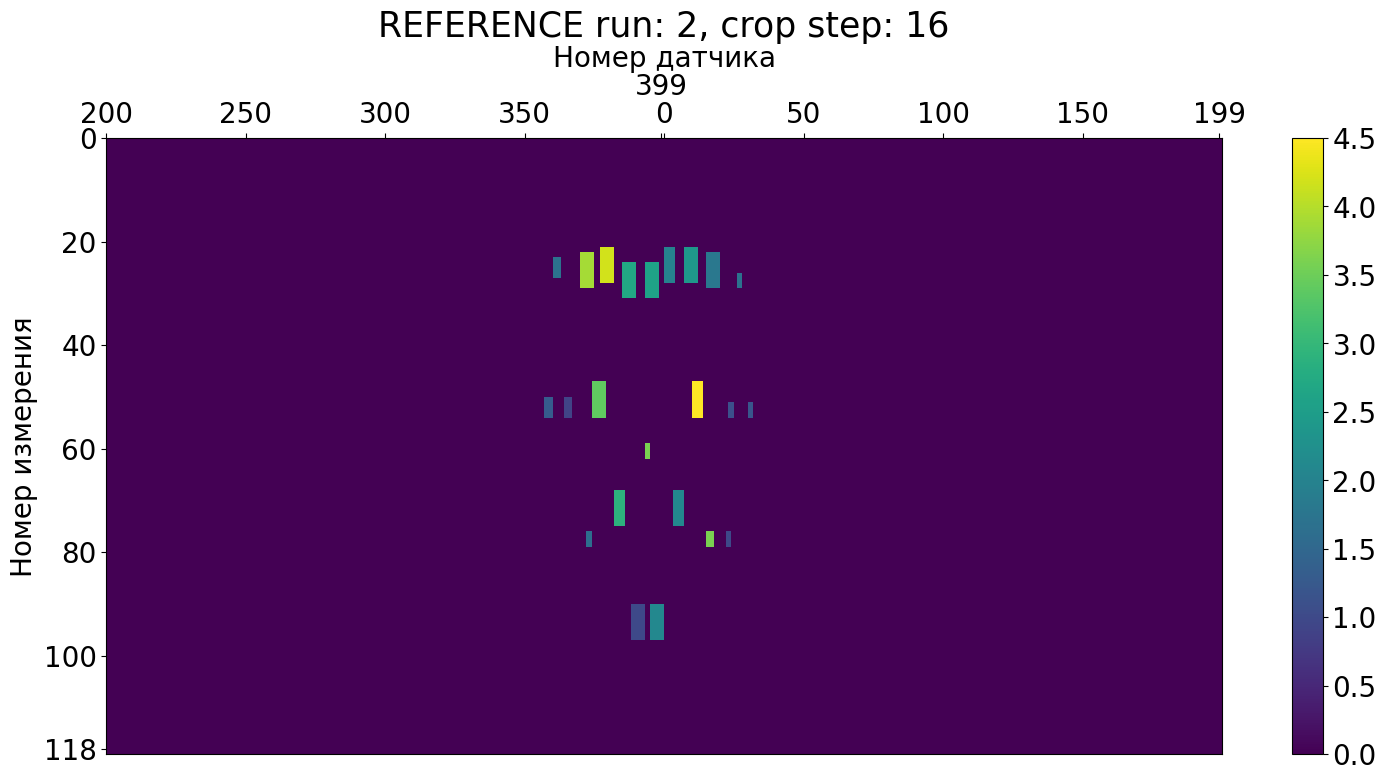

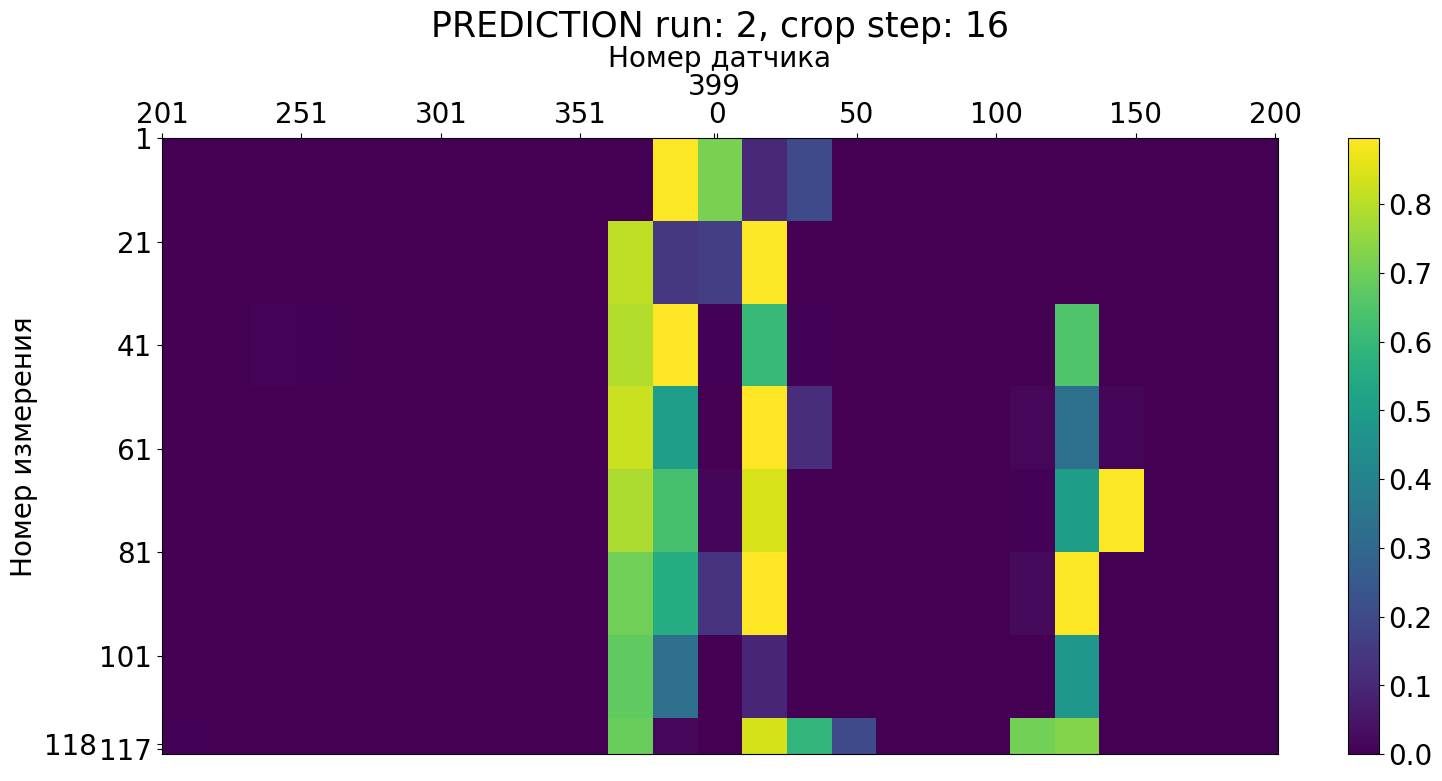

main.make_pred.ipynb ::             <module>() :: run: 2, crop step: 8
main.custom_modules.data_worker.data_worker ::     get_x_and_y_data() :: 
    Read detectors data shape: (119, 400)
    Read defect data shape: (119, 400)
main.custom_modules.data_worker._dataframe_utils :: extend_df_for_prediction() :: 
    The input df shape: (119, 400)
    The crop size: 16
    The output df shape: (149, 430)
main.custom_modules.data_worker._dataframe_utils :: extend_df_for_crops_dividing() :: 
    The input df shape: (149, 430)
    The crop size: 16
    The crop step: 8
    The output df shape: (152, 432)
main.custom_modules.data_worker._dataframe_utils :: extend_df_for_prediction() :: 
    The input df shape: (119, 400)
    The crop size: 16
    The output df shape: (149, 430)
main.custom_modules.data_worker._dataframe_utils :: extend_df_for_crops_dividing() :: 
    The input df shape: (149, 430)
    The crop size: 16
    The crop step: 8
    The output df shape: (152, 432)
main.custom_modules.

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


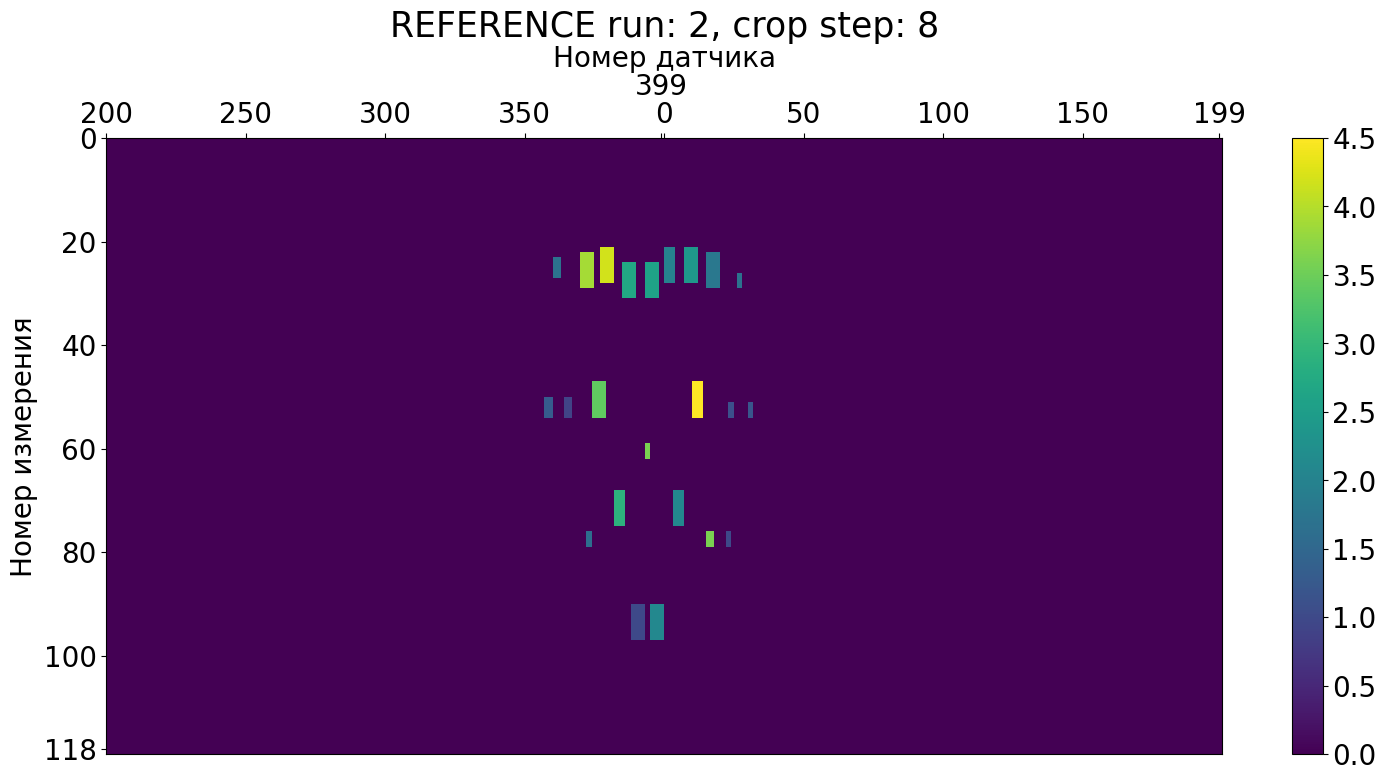

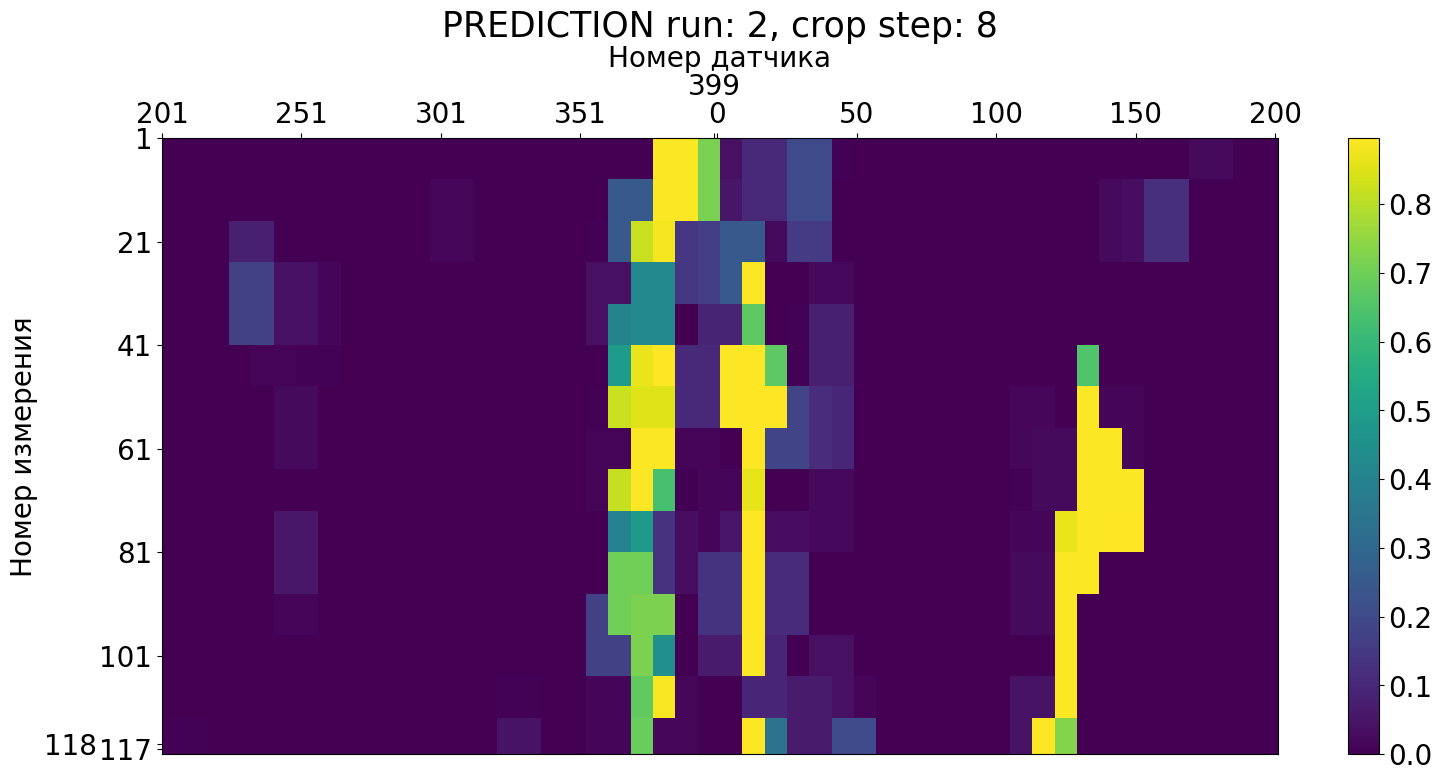

main.make_pred.ipynb ::             <module>() :: run: 2, crop step: 4
main.custom_modules.data_worker.data_worker ::     get_x_and_y_data() :: 
    Read detectors data shape: (119, 400)
    Read defect data shape: (119, 400)
main.custom_modules.data_worker._dataframe_utils :: extend_df_for_prediction() :: 
    The input df shape: (119, 400)
    The crop size: 16
    The output df shape: (149, 430)
main.custom_modules.data_worker._dataframe_utils :: extend_df_for_crops_dividing() :: 
    The input df shape: (149, 430)
    The crop size: 16
    The crop step: 4
    The output df shape: (152, 432)
main.custom_modules.data_worker._dataframe_utils :: extend_df_for_prediction() :: 
    The input df shape: (119, 400)
    The crop size: 16
    The output df shape: (149, 430)
main.custom_modules.data_worker._dataframe_utils :: extend_df_for_crops_dividing() :: 
    The input df shape: (149, 430)
    The crop size: 16
    The crop step: 4
    The output df shape: (152, 432)
main.custom_modules.

115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


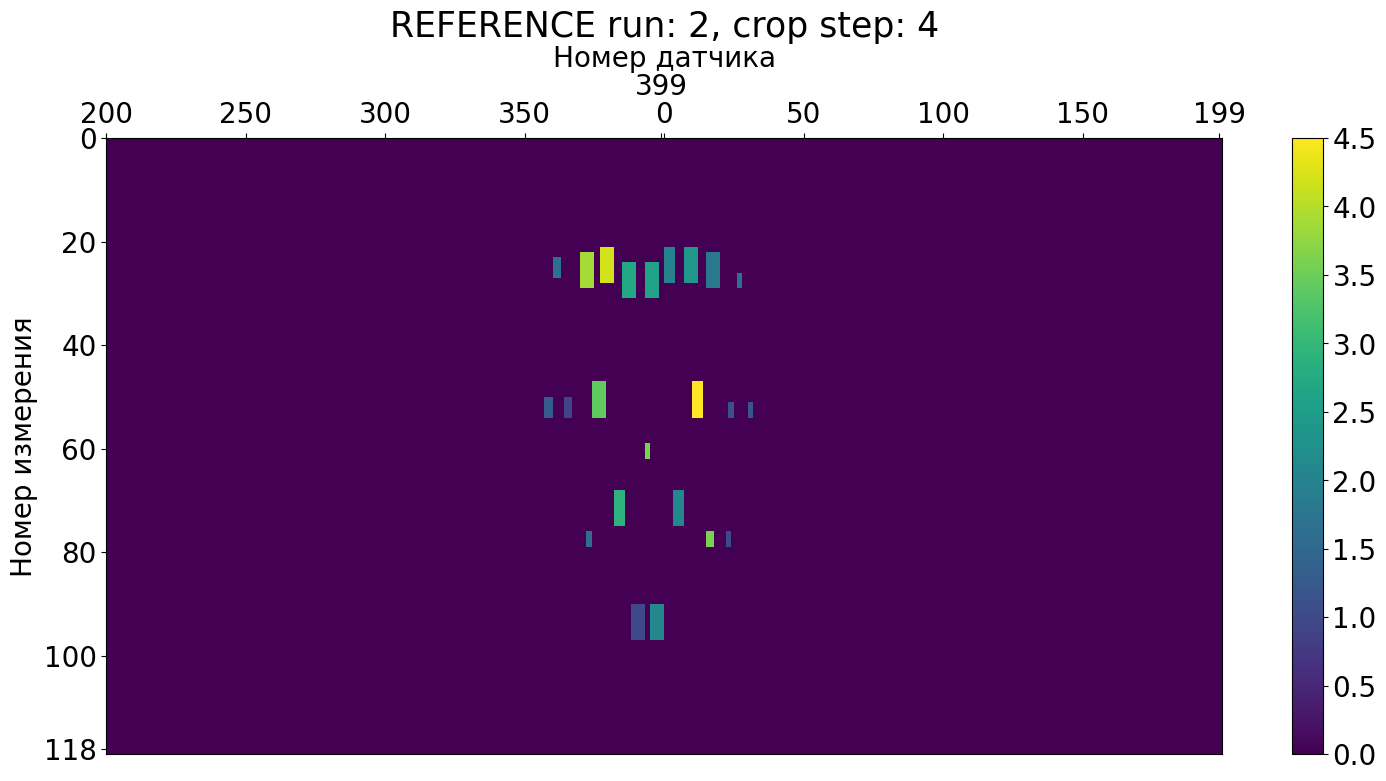

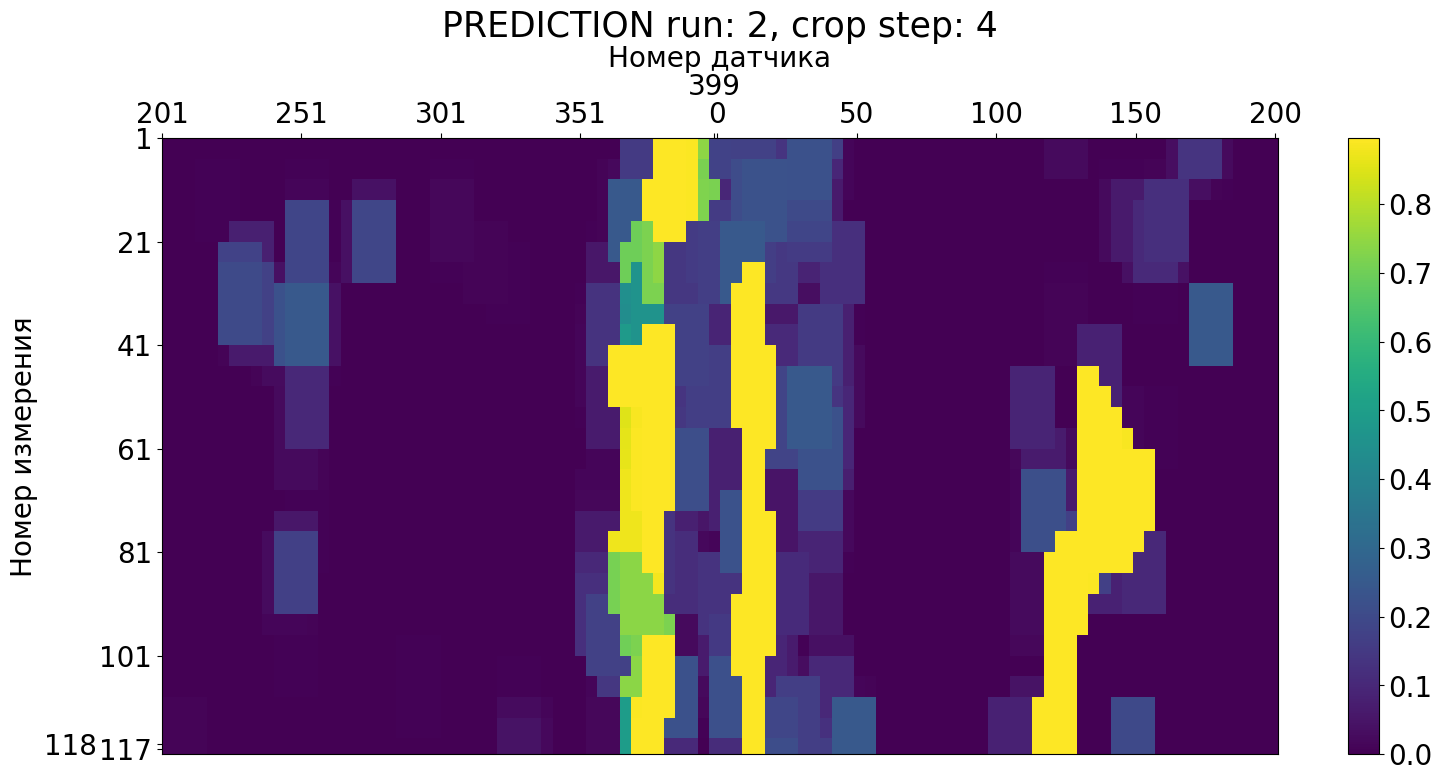

In [8]:
for run in RUNS:
    for crop_step in CROP_STEPS:
        logger.debug(f'run: {run}, crop step: {crop_step}')
        (orig_size_result_df, 
        extend_size_result_df,
        orig_size_reference_df, 
        extend_size_reference_df) = make_pred_fast(load_model, PATH_TO_DATA[f'run_{run}'], XSHIFT, CROP_SIZE, crop_step)

        def calc_mean(df_cell):
            return sum(df_cell) / len(df_cell) 

        def calc_max(df_cell):
            return max(df_cell)

        def calc_quartile(df_cell):
            q1 = [item for item in df_cell if item < 0.25]
            q2 = [item for item in df_cell if item > 0.25 and item < 0.5]
            q3 = [item for item in df_cell if item > 0.5 and item < 0.75]
            q4 = [item for item in df_cell if item > 0.75]
            qrt = [len(q1), len(q2), len(q3), len(q4)]
            ind = qrt.index(max(qrt))
            
            if ind == 0:
                return max(q1)
            elif ind == 1:
                return max(q2)
            elif ind == 2:
                return max(q3)
            else:
                return max(q4)
        
        orig_size_result_df = orig_size_result_df.map(calc_quartile)   
        
        dw.draw_defects_map(orig_size_reference_df, title = f'REFERENCE run: {run}, crop step: {crop_step}')
        dw.draw_defects_map(orig_size_result_df, title = f'PREDICTION run: {run}, crop step: {crop_step}')

                
        #display(orig_size_result_df)
        '''path_to_run = f'data/drawing_data/model_id=v{MODEL_VER}n{MODEL_NUM}/run_{run}/' 
        res_file_name = f'model_id=v{MODEL_VER}n{MODEL_NUM}_crop(size={CROP_SIZE},step={crop_step})_shift(x={XSHIFT},y=0).xlsx'
        
        if not os.path.exists(path_to_run):
            os.makedirs(path_to_run)
        
        with pd.ExcelWriter(os.path.join(path_to_run, res_file_name)) as writer:  
            orig_size_result_df.to_excel(writer, sheet_name='orig_size_result')
            extend_size_result_df.to_excel(writer, sheet_name='extend_size_result')
            
            orig_size_reference_df.to_excel(writer, sheet_name='orig_size_reference')
            extend_size_reference_df.to_excel(writer, sheet_name='extend_size_reference')'''